# viz

In [77]:
import numpy as np 
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import torch
from sklearn.decomposition import PCA

cool_colors = ['#00BEFF', '#D4CA3A', '#FF6DAE', '#67E1B5', '#EBACFA', '#9E9E9E', '#F1988E', '#5DB15A', '#E28544', '#52B8AA']

search_to_color = {'BO': cool_colors[0], 'random': cool_colors[1], 'evolutionary': cool_colors[2], 'RF': cool_colors[5], 'RF (div)': cool_colors[3]}

load data

In [78]:
X = pickle.load(open('inputs_and_outputs.pkl', 'rb'))['X']
print("shape of X:", np.shape(X))
y = pickle.load(open('inputs_and_outputs.pkl', 'rb'))['y']
y = np.reshape(y, (np.size(y), 1)) # for the GP
nb_data = np.size(y)
nb_data

shape of X: (69839, 12)


69839

load search results

In [98]:
bo_res = pickle.load(open('bo_results.pkl', 'rb'))
bo_res

{'nb_runs': 3,
 'nb_iterations': 25,
 'ids_acquired': [array([57214, 54824, 63946, 40684,  5488, 37520, 46393, 50134, 67586,
         53501, 16415, 27798, 27035, 21314, 66263, 33370, 25862, 33366,
         33330, 33355, 33332, 25951, 12402, 33343, 33347]),
  array([ 1739, 54992,  1072,  7535, 28352, 57664,  2012, 17766, 15085,
         68802, 68952, 56517, 12392, 34761, 19518, 33330, 33338, 33332,
         33347, 25951, 33344, 33349, 29861, 26565, 16404]),
  array([53849, 18172, 24262, 11369, 69252,   100,    54, 43031, 11810,
         44138, 15267, 14751, 12392, 66860, 66075, 66117, 33366, 33338,
         66263, 25951, 33332, 33330, 33370, 33347, 33374])]}

In [107]:
rf_res = pickle.load(open('rf_results.pkl', 'rb'))
rf_res

{'nb_runs': 2,
 'nb_evals_budgets': [50, 100, 150, 200],
 'ids_acquired': [[array([10053, 10048, 10055, 10050, 10195, 47861, 14579,  2835, 10075,
          19649, 19498,  5601, 10051,  2691,  9927,    67,   147, 15331,
           2857, 14755, 10184,  8225, 15461, 25449, 15460, 54113,  1468,
          16753, 31407,  1904, 51445, 34974,  6790, 31804, 25930, 51295,
          21591, 41049, 45937, 42528, 66738,  2901, 30411, 14342, 56069,
          36376, 29915, 33878, 28686, 11132]),
   array([13759, 32661, 65995, 32203, 19230, 19231, 19220, 19221, 16567,
          17433, 26639, 19241, 19238, 68549, 29862, 32566, 68389, 32636,
          31975, 25971, 12422, 31130, 31082, 23184, 13763, 57945, 30037,
          19875, 27850, 34542, 39703, 33117, 19471, 12762, 12151, 34077,
          12787, 12269, 65975,  1074, 32528, 60687, 15196, 11411, 13206,
           8192,  6477, 64915, 27400, 23756])],
  [array([59010, 57791, 54590, 37273, 53498, 15480, 58956, 13899, 15227,
          15482, 39133, 53020

# PCA and viz of acquisition of BO

In [80]:
pca = PCA(n_components=2)
pca.fit(X)
X_2D = pca.transform(X)

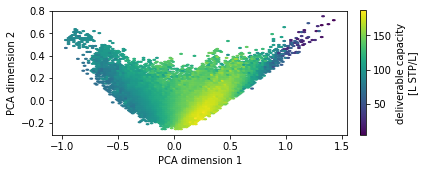

In [81]:
#low dimensional (PCA) visualization of the entire dataset
plt.hexbin(X_2D[:, 0], X_2D[:, 1], C=y)
plt.xlabel('PCA dimension 1')
plt.ylabel('PCA dimension 2')
cb = plt.colorbar(fraction=0.02, pad=0.04)
cb.set_label(label="deliverable capacity\n[L STP/L]")
plt.xticks()
plt.yticks()
plt.gca().set_aspect('equal', 'box')
plt.tight_layout()
plt.savefig('feature_space_colored_by_DC.pdf')

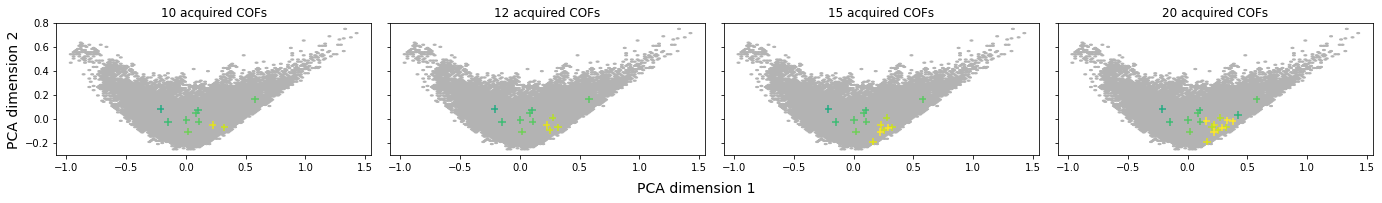

In [85]:
which_BO_run = 0

fig, ax = plt.subplots(1, 4, sharey=True, sharex=True, figsize=[3*6.4, 4.8])
nb_acquired = [10, 12, 15, 20]
# gray background
for a in ax:
    a.set_aspect('equal', 'box')
    a.hexbin(X_2D[:, 0], X_2D[:, 1], C=0.3 * np.ones(nb_data), cmap="binary", vmin=0, vmax=1)
    
for i in range(4):
    ids_acquired = bo_res['ids_acquired'][which_BO_run][:nb_acquired[i]]
    assert len(ids_acquired) == nb_acquired[i]
    # use above colorbar to assign color!
    ax[i].scatter(X_2D[ids_acquired, 0], X_2D[ids_acquired, 1], 
                  c=y[ids_acquired], marker="+", s=55, vmin=cb.vmin, vmax=cb.vmax)
    ax[i].set_title('{} acquired COFs'.format(nb_acquired[i]))
    ax[i].tick_params(axis='x', labelsize=10)
ax[0].set_ylabel('PCA dimension 2', fontsize=14)

ax[2].tick_params(axis='y', labelsize=0)


fig.text(0.5, 0.2, 'PCA dimension 1', ha='center', fontsize=14)
plt.tight_layout()
plt.savefig("feature_space_acquired_COFs.pdf")

# search efficiency
### max $y$ among acquired set.

In [103]:
def y_max(res):
    y_max_mu    = np.zeros(res['nb_iterations'])
    y_max_sigma = np.zeros(res['nb_iterations'])
    for i in range(1, res['nb_iterations']):
        y_maxes = [np.max(y[res['ids_acquired'][r]][:i]) for r in range(res['nb_runs'])]# among runs
        assert np.size(y_maxes) == res['nb_runs']
        y_max_mu[i]    = np.mean(y_maxes)
        y_max_sigma[i] = np.std(y_maxes)
    return y_max_mu, y_max_sigma

y_max_mu, y_max_sigma = y_max(bo_res)

TypeError: missing a required argument: 'x'

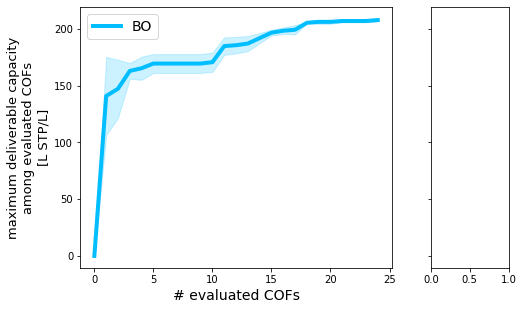

In [104]:
fig, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios': [4, 1]}, figsize=[1.2 * 6.4, 4.8], sharey=True)
# BO
axs[0].plot(np.arange(bo_res['nb_iterations']), y_max_mu, label='BO', color=search_to_color['BO'], lw=4, clip_on=False)
axs[0].fill_between(np.arange(bo_res['nb_iterations']), y_max_mu - y_max_sigma, 
                                                        y_max_mu + y_max_sigma, 
                    alpha=0.2, ec="None", color=search_to_color['BO'])

axs[0].set_xlabel('# evaluated COFs', fontsize=14)
axs[0].set_ylabel('maximum deliverable capacity\namong evaluated COFs\n[L STP/L]', fontsize=13)
axs[0].legend(fontsize=14)

# RF
axs[0].scatter(rf_res['nb_evals_budgets'], ref_res[]

# axs[0].set_xlim([0, ])
axs[0].set_ylim(ymin=0.0)

axs[1].hist(y, orientation="horizontal", color=cool_colors[7])
axs[1].set_xlabel("# COFs", fontsize=13)
axs[1].set_xscale("log")
plt.tight_layout()
plt.savefig("search_efficiency_max_found.pdf")

### max rank among acquired set

### fraction of top 100 COFs recovered